## Detecting communities in the rock network

### *Import network*

In [34]:
import json, random, math, re, unicodedata
import networkx as nx
from collections import defaultdict, Counter
from networkx.algorithms.community.quality import modularity as nx_modularity

# ----- load graph -----
G = nx.read_gexf("../graph/rock_network.gexf")

### *Map extracted genres to the rock network*

In [ ]:
from difflib import SequenceMatcher

GENRES_JSON = "../genres/genres.json"
RANDOM_SEED = 42

# Ensure undirected simple graph
if G.is_directed():
    G = G.to_undirected(as_view=False)
G = nx.Graph(G)

# load genres
genres_raw = json.load(open(GENRES_JSON, encoding="utf-8"))

# --- name normalization helpers ---
QUOTES = {"’":"'", "‘":"'", "“":'"', "”":'"', "´":"'", "`":"'"}
DASHES = {"–":"-", "—":"-", "−":"-"}

def normalize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s).strip()
    for a,b in QUOTES.items(): s = s.replace(a,b)
    for a,b in DASHES.items(): s = s.replace(a,b)
    s = s.replace("_", " ")
    s = s.replace(" & ", " and ")
    s = re.sub(r"[.,!?:;]+", " ", s)
    s = re.sub(r"\s*-\s*", "-", s)    # collapse spaces around hyphens
    s = re.sub(r"\s+", " ", s)
    return s.lower()

def strip_the(s: str) -> str:
    return re.sub(r"^\s*the\s+", "", s, flags=re.I)

def drop_parentheses(s: str) -> str:
    return re.sub(r"\s*\([^)]*\)\s*$", "", s).strip()

def variants(name: str):
    base = normalize_name(name)
    yield base
    yield strip_the(base)
    yield drop_parentheses(base)
    yield strip_the(drop_parentheses(base))

# Build normalized index from your JSON keys
index = {}
for k in genres_raw.keys():
    for v in set(variants(k)):
        index.setdefault(v, []).append(k)

def resolve_node(n: str) -> str | None:
    # 1) Hard alias override (may return None to skip)
    if n in HARD_ALIASES:
        return HARD_ALIASES[n]

    # 2) Variant-based lookup
    for v in variants(n):
        if v in index:
            cand_list = index[v]
            if len(cand_list) == 1:
                return cand_list[0]
            # tie-break by similarity on raw strings
            return max(cand_list, key=lambda k: SequenceMatcher(None, normalize_name(k), normalize_name(n)).ratio())
    return None

# --- Hard aliases: graph node label -> EXACT key in the genres JSON (or None to skip) ---
# used to fix specific mismatches between the graph and the genres JSON
HARD_ALIASES = {
    "AllMusic": None,  # drop; not an artist

    # These 4 use spaced hyphens in your JSON:
    "Bachman-Turner_Overdrive": "Bachman –Turner Overdrive",   # note space before en dash
    "The_Go-Go's":              "The Go -Go's",
    "Parliament-Funkadelic":    "Parliament -Funkadelic",
    "The_All-American_Rejects": "The All -American Rejects",

    # Dallas Green -> City and Colour (article name)
    "Dallas_Green_(musician)":  "City and Colour",
}

# --- function to resolve a graph node to a JSON key ---
def resolve_node(n: str) -> str | None:
    # try exact variants
    for v in variants(n):
        if v in index:
            # if multiple JSON keys map to same normalized variant, prefer the one with closest raw match
            if len(index[v]) == 1:
                return index[v][0]
            # tie-break by similarity
            cand = max(index[v], key=lambda k: SequenceMatcher(None, normalize_name(k), normalize_name(n)).ratio())
            return cand
    return None

# --- measure coverage and show examples ---
resolved, unresolved = {}, []
for n in G.nodes():
    key = resolve_node(n)
    if key is None:
        unresolved.append(n)
        continue
    gl = genres_raw.get(key, [])
    if not gl:
        unresolved.append(n)
        continue
    resolved[n] = key

print(f"Original: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
print(f"Matched (non-empty genres): {len(resolved):,} nodes")
if unresolved:
    print("Unmatched sample:", ", ".join(map(str, unresolved[:12])))

H = G.subgraph(list(resolved.keys())).copy()
print(f"Working subgraph: {H.number_of_nodes():,} nodes, {H.number_of_edges():,} edges")


Original: 486 nodes, 6,879 edges
Matched (non-empty genres): 484 nodes
Unmatched sample: AllMusic, Dallas_Green_(musician)
Working subgraph: 484 nodes, 6,519 edges


### *Genre communities and modularity*

In [41]:
import random
from collections import defaultdict, Counter
import networkx as nx
from networkx.algorithms.community.quality import modularity as nx_modularity

# ---------- config ----------
RANDOM_SEED = 42
# ---------------------------

assert 'H' in globals(), "I expected a subgraph H with the nodes you keep."
assert 'resolved' in globals(), "I expected a dict 'resolved' mapping node -> genres info."

# Helper: get genre list for a node from your 'resolved' dict, respecting your original values.
def get_genres(n):
    # Get the JSON key for this node
    json_key = resolved[n]
    # Get the genres list from the raw genres data
    gl = genres_raw.get(json_key, [])
    # Use as-is (no normalization); just ensure it's a list of non-empty strings
    return [g for g in gl if str(g).strip()]

# Build communities from node labels
def communities_from_labels(graph, labels_dict):
    groups = defaultdict(set)
    for node, label in labels_dict.items():
        groups[label].add(node)
    # drop empties (shouldn't happen)
    return [s for s in groups.values() if s]

# Print partition stats
def part_stats(title, labels_dict, graph):
    c = Counter(labels_dict.values())
    sizes = sorted(c.values())
    median = sizes[len(sizes)//2] if sizes else 0
    print(f"\n[{title}] groups={len(c)}  avg size={graph.number_of_nodes()/max(1,len(c)):.1f}  median size={median}")
    for lab, sz in c.most_common(10):
        print(f"  - {lab}: {sz}")

print(f"Working subgraph: {H.number_of_nodes():,} nodes, {H.number_of_edges():,} edges")

# A) FIRST GENRE
labels_first = {}
for n in H.nodes():
    gl = get_genres(n)
    if not gl:
        continue
    labels_first[n] = gl[0]  # <-- use first genre exactly as stored
comms_first = communities_from_labels(H, labels_first)
Q_first = nx_modularity(H, comms_first)
part_stats("First-genre partition", labels_first, H)
print(f"\nModularity Q (first genre): {Q_first:.4f}")

# B) RANDOM GENRE for multi-genre nodes
rng = random.Random(RANDOM_SEED)
labels_rand = {}
for n in H.nodes():
    gl = get_genres(n)
    if not gl:
        continue
    labels_rand[n] = gl[0] if len(gl) == 1 else rng.choice(gl)
comms_rand = communities_from_labels(H, labels_rand)
Q_rand = nx_modularity(H, comms_rand)
part_stats("Random-genre partition (multi-genre randomized)", labels_rand, H)
print(f"\nModularity Q (random genre): {Q_rand:.4f}")

labels_spec = {n: get_genres(n)[0] for n in H.nodes()}
comms_spec = communities_from_labels(H, labels_spec)
Q_spec = nx_modularity(H, comms_spec)


Working subgraph: 484 nodes, 6,519 edges

[First-genre partition] groups=81  avg size=6.0  median size=2
  - rock: 75
  - alternative rock: 63
  - hard rock: 49
  - pop rock: 20
  - heavy metal: 16
  - progressive rock: 16
  - rock and roll: 15
  - alternative metal: 13
  - new wave: 12
  - post grunge: 11

Modularity Q (first genre): 0.0897

[Random-genre partition (multi-genre randomized)] groups=117  avg size=4.1  median size=2
  - hard rock: 42
  - rock: 32
  - alternative rock: 31
  - heavy metal: 20
  - pop rock: 19
  - pop: 17
  - blues rock: 16
  - soft rock: 14
  - post grunge: 13
  - art rock: 11

Modularity Q (random genre): 0.0433


### *Louvain communities and modularity*

In [ ]:
import sys
import networkx as nx
import community as community_louvain

assert 'H' in globals(), "I expected subgraph H (only nodes with genres)."

# Compute Louvain partition on the undirected simple graph
if H.is_directed():
    H = H.to_undirected(as_view=False)
H = nx.Graph(H)

louvain_part = community_louvain.best_partition(H)  # dict: node -> community_id (int)
Q_louvain = community_louvain.modularity(louvain_part, H)

# Quick stats
from collections import Counter
counts = Counter(louvain_part.values())
print(f"Louvain: {len(counts)} communities")
for cid, sz in counts.most_common(10):
    print(f"  - c{cid}: {sz} nodes")
print(f"\nModularity Q (Louvain): {Q_louvain:.4f}")


Louvain: 5 communities
  - c2: 167 nodes
  - c4: 112 nodes
  - c1: 103 nodes
  - c0: 98 nodes
  - c3: 4 nodes

Modularity Q (Louvain): 0.3333


### *ForceAtlas visualization of the network with its communities*

C:\Users\Malin Haugland Høli\AppData\Local\Temp\ipykernel_41220\3864014090.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = get_cmap("tab20")


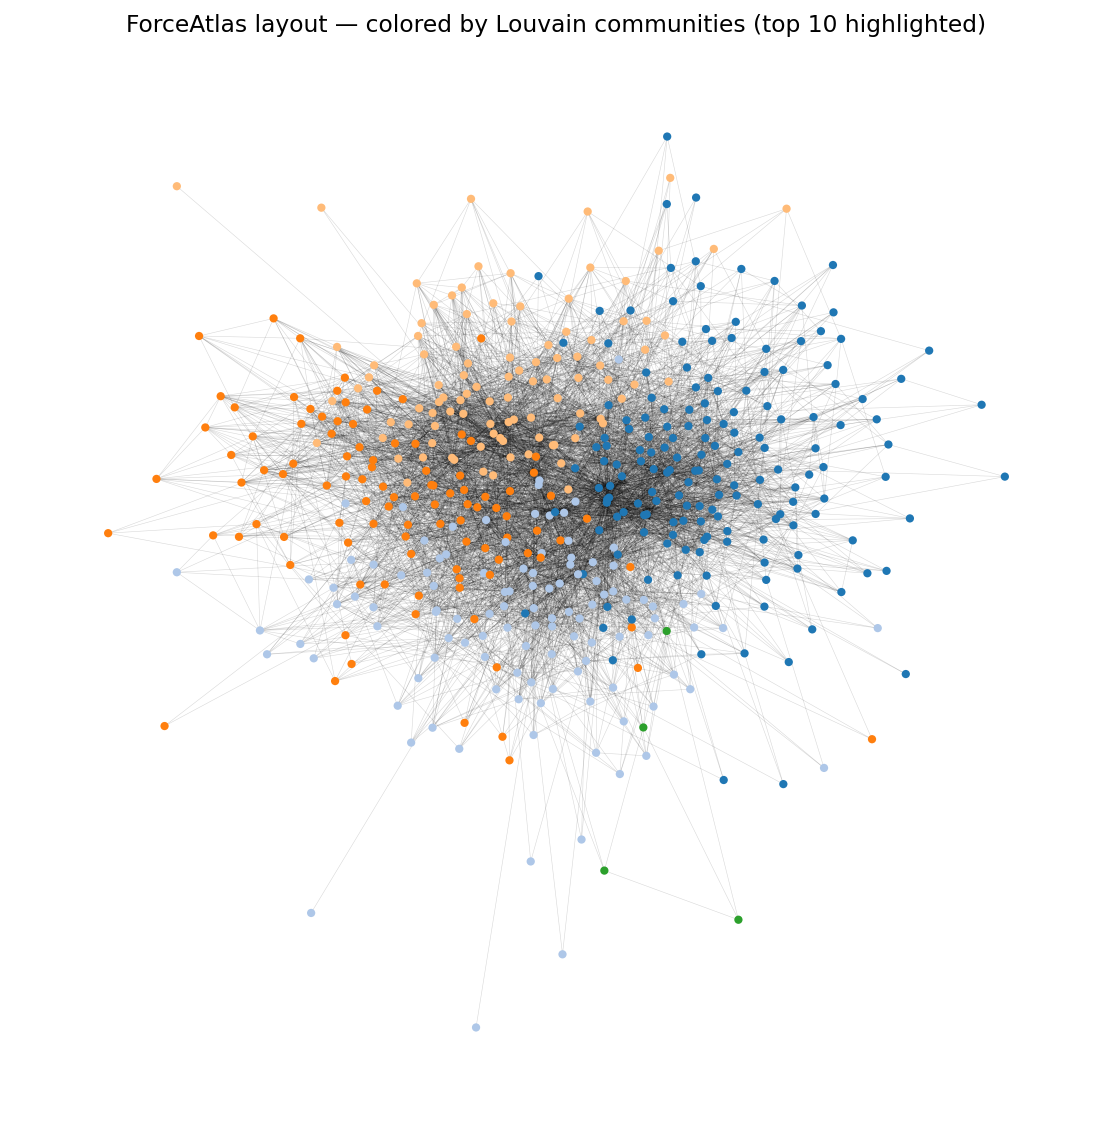

In [38]:
# --- ForceAtlas-style layout (fa2) with fallback to spring_layout ---
import math
import matplotlib.pyplot as plt

# Try ForceAtlas2
pos = None
try:
    from fa2 import ForceAtlas2
    fa2 = ForceAtlas2(
        outboundAttractionDistribution=False,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
        verbose=False
    )
    pos = fa2.forceatlas2_networkx_layout(H, pos=None, iterations=800)
except Exception:
    # Fallback: Fruchterman-Reingold
    pos = nx.spring_layout(H, k=1/math.sqrt(H.number_of_nodes()), iterations=300, seed=42)

# Map communities to colors (top K colored, others gray)
from matplotlib.cm import get_cmap
from collections import Counter, defaultdict

K = 10  # color the largest K communities
counts = Counter(louvain_part.values())
largest = [cid for cid,_ in counts.most_common(K)]
palette = get_cmap("tab20")

color_map = {}
for i, cid in enumerate(largest):
    color_map[cid] = palette(i % 20)
OTHER_COLOR = (0.8, 0.8, 0.8, 0.4)  # light gray for small communities

node_colors = [color_map.get(louvain_part[n], OTHER_COLOR) for n in H.nodes()]

plt.figure(figsize=(10, 10), dpi=140)
# light edges
nx.draw_networkx_edges(H, pos, width=0.3, alpha=0.15)
# nodes
nx.draw_networkx_nodes(H, pos, node_size=18, node_color=node_colors, linewidths=0)
plt.axis("off")
plt.title(f"ForceAtlas layout — colored by Louvain communities (top {K} highlighted)", fontsize=12)
plt.show()


### *Confusion matrix* 

Top genres: ['hard rock', 'alternative rock', 'pop rock', 'rock', 'alternative metal', 'blues rock', 'pop']
Top communities: [2, 4, 1, 0, 3]


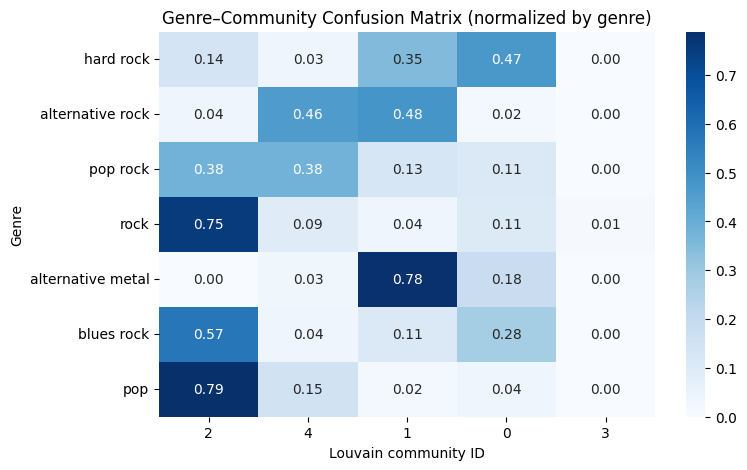

In [39]:
import pandas as pd
from collections import Counter, defaultdict

# --- 2) Determine top 7 genres and top 7 communities ---
all_genres = []
for n in H.nodes():
    g_list = get_genres(n)
    all_genres.extend(g_list)
top_genres = [g for g, _ in Counter(all_genres).most_common(7)]

top_comms = [c for c, _ in Counter(louvain_part.values()).most_common(7)]

print("Top genres:", top_genres)
print("Top communities:", top_comms)

# --- 3) Build confusion matrix ---
conf = pd.DataFrame(0, index=top_genres, columns=top_comms, dtype=int)

for n in H.nodes():
    genres = get_genres(n)
    cid = louvain_part.get(n)
    if cid not in top_comms:
        continue
    for g in genres:
        if g in top_genres:
            conf.loc[g, cid] += 1

# Optional: normalize rows to proportions
conf_norm = conf.div(conf.sum(axis=1), axis=0).fillna(0)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(conf_norm, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel("Louvain community ID")
plt.ylabel("Genre")
plt.title("Genre–Community Confusion Matrix (normalized by genre)")
plt.show()
